In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Exercise 1: Feature points detectors

## a) Hessian matrix

In [42]:
def gauss(sigma, size = -1, rng = False):
	if size == -1:
		size = 6 * sigma + 1
	kern = np.arange(-size // 2 + size % 2, size // 2 + size % 2)
	kern = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-(kern ** 2) / (2 * (sigma ** 2)))
	kern /= np.sum(kern)

	if rng == True:
		return kern, np.arange(-size // 2 + size % 2, size // 2 + size % 2)
	else:
		return kern

def gaussdx(sigma, size = -1, rng = False):
	if size == -1:
		size = 6 * sigma + 1
	kern = np.arange(-size // 2 + size % 2, size // 2 + size % 2)
	kern = -(1 / (np.sqrt(2 * np.pi) * sigma ** 3)) * kern * np.exp(-(kern ** 2) / (2 * (sigma ** 2)))
	kern /= np.sum(np.abs(kern))

	if rng == True:
		return kern, np.arange(-size // 2 + size % 2, size // 2 + size % 2)
	else:
		return kern

def partial_derivatives(img, sigma):
	gkern = np.array([gauss(sigma)])
	dkern = np.array([gaussdx(sigma)])
	Ix = np.copy(img).astype(np.float32)
	Iy = np.copy(img).astype(np.float32)
	Ix = cv2.filter2D(Ix, -1, gkern)
	Ix = cv2.filter2D(Ix, -1, np.fliplr(dkern))
	Iy = cv2.filter2D(Iy, -1, gkern.T)
	Iy = cv2.filter2D(Iy, -1, np.flipud(dkern.T))

	Ixx = np.copy(Ix).astype(np.float32)
	Ixy = np.copy(Ix).astype(np.float32)
	Iyy = np.copy(Iy).astype(np.float32)
	Ixx = cv2.filter2D(Ixx, -1, gkern)
	Ixx = cv2.filter2D(Ixx, -1, np.fliplr(dkern))
	Ixy = cv2.filter2D(Ixy, -1, gkern.T)
	Ixy = cv2.filter2D(Ixy, -1, np.flipud(dkern.T))
	Iyy = cv2.filter2D(Iyy, -1, gkern.T)
	Iyy = cv2.filter2D(Iyy, -1, np.flipud(dkern.T))

	return Ix, Iy, Ixx, Ixy, Iyy

def gradient_magnitude(ix, iy):
	ix = ix.astype(np.float32)
	iy = iy.astype(np.float32)
	magnitude = np.sqrt(ix ** 2 + iy ** 2)
	angle = np.arctan2(ix, iy)
	return magnitude, angle

def nms(img, sigma, threshold):
	ix, iy, _, _, _ = partial_derivatives(img, sigma)
	mag, dir = gradient_magnitude(ix, iy)
	dir = np.round(8 * (dir + np.pi) / (2 * np.pi)) % 4 # [-pi, pi] -> [0, 3]
	mag[mag < threshold] = 0
	img = np.copy(mag)
	for i in range(len(dir) - 1):
		for j in range(len(dir[i]) - 1):
			d = dir[i,j]
			m = mag[i,j]
			if d == 0: # 0°
				if mag[i-1, j] > m or mag[i+1, j] > m:
					img[i,j] = 0
			elif d == 1: # 45°
				if mag[i-1, j-1] > m or mag[i+1, j+1] > m:
					img[i,j] = 0
			elif d == 2: # 90°
				if mag[i, j-1] > m or mag[i, j+1] > m:
					img[i,j] = 0
			elif d == 3: # 135°
				if mag[i+1, j-1] > m or mag[i-1, j+1] > m:
					img[i,j] = 0
	img[img > 0] = 1
	return img

In [36]:
def hessian_points(img, sigma, threshold):
	Ix, Iy, Ixx, Ixy, Iyy = partial_derivatives(img, sigma)
	h_det = sigma ** 4 * (Ixx * Iyy - Ixy ** 2)

	return h_det, np.argwhere(nms(h_det, sigma, threshold) != 0)

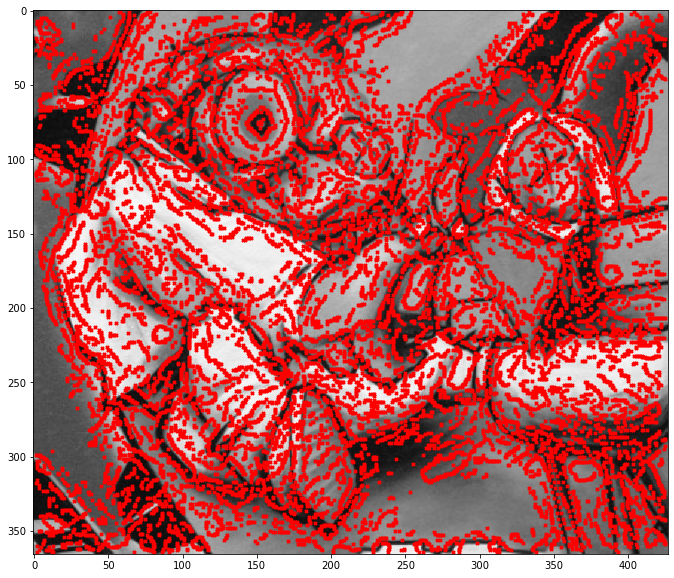

In [49]:
img_points = cv2.cvtColor(cv2.imread('data/test_points.jpg'), cv2.COLOR_BGR2GRAY)
det, points = hessian_points(img_points, 3, 120)

plt.figure(figsize=(15,10))
plt.imshow(img_points, cmap='gray')
plt.scatter(points[:,1], points[:,0], s = 10, c = 'red', marker = 'X')
plt.show()

## b) Harris feature detection

In [ ]:
def convolve(img, kernel):
	img = np.copy(img)
	img = cv2.filter2D(img, -1, kernel)
	img = cv2.filter2D(img, -1, kernel.T)
	return img

def harris_feature_detection(img, sigma, threshold):
	Ix, Iy, _, Ixy, _ = partial_derivatives(img, sigma)
	gkern = np.array([gauss(1.6 * sigma)])
	alpha = 0.06

	h_mat = [
		[convolve(Ix ** 2, gkern), convolve(Ixy ** 2, gkern)],
		[convolve(Ixy ** 2, gkern), convolve(Iy ** 2, gkern)]
	]

	h_det = np.linalg.det(h_mat)
	h_trace = np.trace(h_mat)

	return h_det - alpha * h_trace ** 2 > threshold

# Exercise 2: Matching local regions

# Exercise 3: Homography estimation